## Transpilation of circuits using qiskit-ibm-transpiler

In this notebook, we show how you can get the most out of the AI Transpiler passes.

You can find an overview in this blog post:

- [https://www.ibm.com/quantum/blog/ai-transpiler-passes](https://www.ibm.com/quantum/blog/ai-transpiler-passes)

More detailed documentation can be found here:

- [https://docs.quantum.ibm.com/guides/ai-transpiler-passes](https://docs.quantum.ibm.com/guides/ai-transpiler-passes)

And you can check the arXive paper for the details on the AI methods:

- [https://arxiv.org/abs/2405.13196](https://arxiv.org/abs/2405.13196)


Based on https://github.com/ajavadia/ieee-quantum-week-2024/blob/main/ai-transpiling-tutorial.ipynb

In [1]:
# Let's install the required libraries to run this notebook 
# For the qiskit-ibm-transpiler library we include the `ai-local-mode` dependency which allows any user to utilize the
# AI-powered transpiler passes in their computers in contrast to the Qiskit Transpiler Service which is available only for IBM Quantum Premium users.

# Required Qiskit packages
# !pip install -U "qiskit-ibm-transpiler[ai-local-mode]"
# !pip install -U qiskit_ibm_runtime

# Required libraries for visualization
# !pip install matplotlib
# !pip install pylatexenc

In [2]:
from qiskit import QuantumCircuit

def print_2q_count_and_depth(circuit):
    circuit_without_swaps = circuit.decompose("swap")
    print(f"2q gates: {circuit_without_swaps.num_nonlocal_gates()} | 2q depth: {circuit_without_swaps.depth(lambda op: len(op.qubits)>=2)}")

def return_2q_count_and_depth(circuit):
    circuit_without_swaps = circuit.decompose("swap")
    return {"2q_gates": circuit_without_swaps.num_nonlocal_gates(),
            "2q_depth": circuit_without_swaps.depth(lambda op: len(op.qubits)>=2)}

def calculate_2q_count_and_depth_improvement(circuit1, circuit2):
    # Calculate improvement
    circuit1_gates = return_2q_count_and_depth(circuit1).get("2q_gates")
    circuit2_gates = return_2q_count_and_depth(circuit2).get("2q_depth")
    improvement = ((circuit1_gates - circuit2_gates) / circuit1_gates) * 100

    print(f"\nImprovement: {improvement:.1f}% reduction in 2q gates")

    circuit1_depth = return_2q_count_and_depth(circuit1).get("2q_depth")
    circuit2_depth = return_2q_count_and_depth(circuit2).get("2q_depth")
    improvement = ((circuit1_depth - circuit2_depth) / circuit1_depth) * 100
    print(f"\nImprovement: {improvement:.1f}% reduction in 2q depth")

def fix_gate_names(circuit):
    # Fix gate names for display
    for gate in circuit:
        if gate.operation.name.startswith("unitary"):
            gate.operation.name = "unitary"
    return circuit


# 1. Playing with AI Transpiler Passes in local mode

### 1.1 AI Synthesis

AI Synthesis passes allow you synthesize Clifford, LinearFunction, Permutation and PauliNetwork blocks following a given coupling map.

They are guarenteed to implement the exact operation following the coupling map, and provide a good balance between optimality and computation time. By default, the passes run in your local environment instead of in the cloud.

In [3]:
from qiskit_ibm_transpiler.ai.synthesis import AILinearFunctionSynthesis, AIPermutationSynthesis, AICliffordSynthesis, AIPauliNetworkSynthesis

from qiskit_ibm_transpiler.ai.collection import CliffordInstruction
from qiskit.circuit.library import LinearFunction, PermutationGate

#### Clifford circuits

Cliffor circuits are circuits that can be implemented with H, S and CX gates (more info [here](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Clifford)).

Any Clifford circuit can be expressed as a 2N by 2N boolean matrix plus a 2N boolean vector for phase.

We can create a random 6 qubit Clifford like this:

In [4]:
from qiskit.quantum_info import Clifford, random_clifford
some_clifford = random_clifford(6)
some_clifford

Clifford(array([[False,  True, False,  True,  True,  True,  True,  True, False,
         True, False, False, False],
       [ True, False, False, False,  True, False,  True,  True, False,
         True, False,  True, False],
       [False,  True, False, False, False, False, False,  True,  True,
         True,  True, False,  True],
       [ True,  True,  True, False, False,  True,  True, False, False,
        False, False, False,  True],
       [False,  True, False,  True, False, False, False, False, False,
        False, False, False,  True],
       [False,  True,  True, False, False, False, False, False, False,
        False,  True, False,  True],
       [False, False, False,  True,  True, False, False, False,  True,
        False,  True,  True,  True],
       [False, False,  True, False, False,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True, False, False,  True, False,  True, False, False, False,
        False,  True,  True,  True],
       [False,  Tru

We can get an implementation of this Clifford with the standard method in Qiskit SDK, but it does not follow any coupling map (it assumes full connectivity):

2q gates: 23 | 2q depth: 21


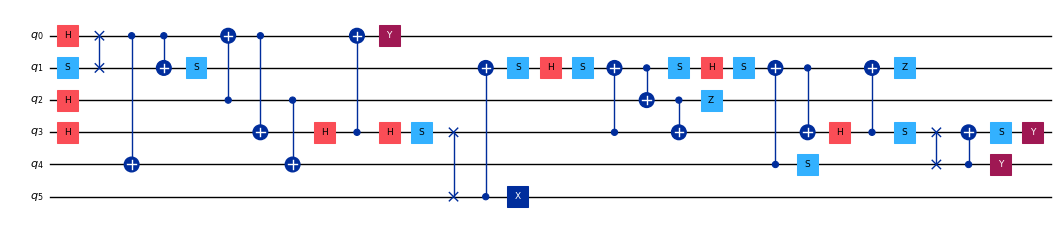

In [5]:
some_clifford_circuit = QuantumCircuit(some_clifford.num_qubits)
some_clifford_circuit.append(some_clifford, range(some_clifford_circuit.num_qubits))
some_clifford_circuit = some_clifford_circuit.decompose("clifford")

print_2q_count_and_depth(some_clifford_circuit)
some_clifford_circuit.draw(output="mpl", fold=-1, scale=0.5)

If we wanted to make this follow a coupling map, we would have to run a routing algorithm (e.g. `SabreSwap`). 

Lets transpile it for linear connectivity:

2q gates: 71 | 2q depth: 54


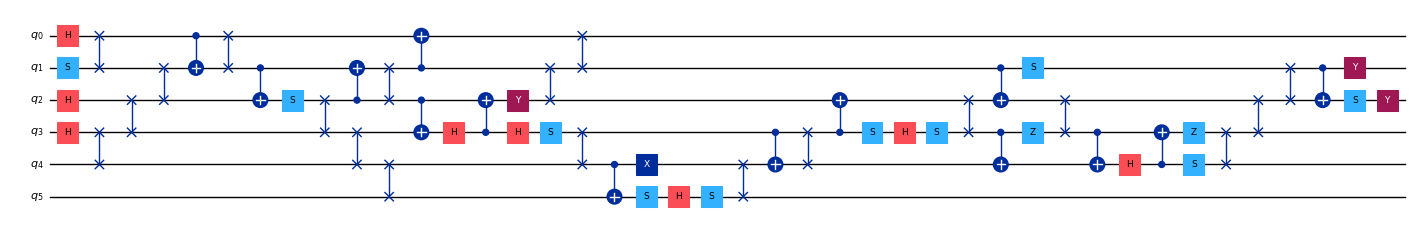

In [6]:
from qiskit.transpiler.passes import SabreSwap
from qiskit.transpiler import CouplingMap

coupling_map_6qL = CouplingMap.from_line(some_clifford_circuit.num_qubits)
sabre_swap = SabreSwap(coupling_map=coupling_map_6qL)

some_clifford_circuit_routed = sabre_swap(some_clifford_circuit)

print_2q_count_and_depth(some_clifford_circuit_routed)
some_clifford_circuit_routed.draw(output="mpl", fold=-1, scale=0.5)

We can see that this would work but there may be better ways to do it with less overhead. 

Also, note that after the routing we are not guaranteed to revert the final permutation, so we cannot use this as it is if we wanted to replace a clifford block within a larger circuit:

In [7]:
Clifford(some_clifford_circuit_routed) == some_clifford

np.False_

Lets see how we can do this with the `AICliffordSynthesis` pass.

First we embed the clifford into a block:

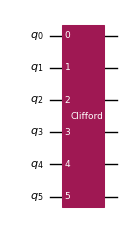

In [8]:
some_clifford_circuit_block = QuantumCircuit(some_clifford_circuit.num_qubits)
some_clifford_circuit_block.append(CliffordInstruction(some_clifford_circuit), range(some_clifford_circuit.num_qubits))

some_clifford_circuit_block.draw(output="mpl", fold=-1, scale=0.5)

Then we generate an instance of the `AICliffordSynthesis`:

In [9]:
ai_clifford_synth = AICliffordSynthesis(
    coupling_map=list(coupling_map_6qL.get_edges()),   # WIP (should be "coupling_map=...")
    replace_only_if_better=False,  # This means the pass will replace the block even if it has more cx than original circuit
)

Finally, we run the Synthesis on the circuit:

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Clifford AI synthesis on local mode


2q gates: 22 | 2q depth: 15


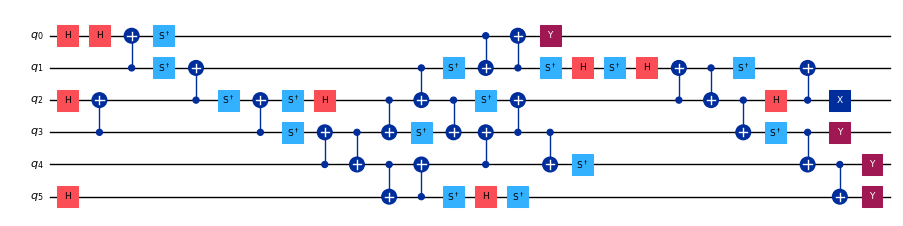

In [10]:
some_clifford_ai_synth = ai_clifford_synth(some_clifford_circuit_block)

print_2q_count_and_depth(some_clifford_ai_synth)
some_clifford_ai_synth.draw(output="mpl", fold=-1, scale=0.5)

We can see that the circuit follows the coupling map, and uses much less CX gates (around 50%-70% for random Cliffords).

We can also check that it implements the exact Clifford including final permutations:

In [11]:
Clifford(some_clifford_ai_synth) == some_clifford

np.True_

### *Hands-on exercise*:
*Try Clifford synthesis on a 7 qubit 'H' shaped coupling map*

In [ ]:
#...

#### LinearFunctions and Permutations

LinearFunctions are circuits that can be implemented with CX gates (so they are a subset of Cliffords), and can be represented by a boolean N by N matrix.

Permutations are a subset of LinearFunctions and can be implemented with SWAP gates. They implement a permutation of the qubits so they can be represented by a permutation array of N elements.

We can do AI Synthesis in the same way as for Cliffords.

First we build a LinearFunction with a CX between qubit 0 and qubit 7:

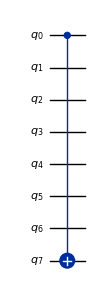

In [12]:
# The original circuit
some_lf_circuit = QuantumCircuit(8)
some_lf_circuit.cx(0,7)
some_lf_circuit.draw(output="mpl", fold=-1, scale=0.5)

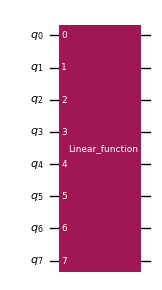

In [13]:
# The LinearFunction object
some_lf = LinearFunction(some_lf_circuit)

# The block with the LinearFunction
some_lf_block = QuantumCircuit(some_lf.num_qubits)
some_lf_block.append(some_lf, range(some_lf_block.num_qubits))

some_lf_block.draw(output="mpl", fold=-1, scale=0.5)

Then we generate our `AILinearFunctionSynthesis` pass:

In [14]:
coupling_map_8qL = CouplingMap.from_line(some_lf_block.num_qubits)

ai_lf_synth = AILinearFunctionSynthesis(
    coupling_map=list(coupling_map_8qL.get_edges()),   # WIP (should be "coupling_map=...")
    replace_only_if_better=False,
)

And we run the pass on the circuit:

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


2q gates: 24 | 2q depth: 19


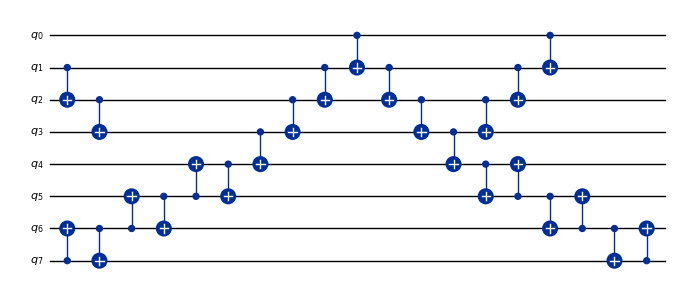

In [15]:
some_lf_ai_synth = ai_lf_synth(some_lf_block)

print_2q_count_and_depth(some_lf_ai_synth)
some_lf_ai_synth.draw(output="mpl", fold=-1, scale=0.5)

### *Hands-on exercise*:
*Compare with running routing on the single CX circuit*

In [ ]:
#...

### *Hands-on exercise*:
*Implement a full inversion permutation on 27 qubits heavy-hex with the `AIPermutationSynthesis` pass*.

*Also compare with `TokenSwapperSynthesisPermutation`*.

In [16]:
from qiskit.transpiler.passes.synthesis.hls_plugins import TokenSwapperSynthesisPermutation
from qiskit_ibm_runtime.fake_provider.backends.montreal import FakeMontrealV2

coupling_map_27qHH = FakeMontrealV2().coupling_map

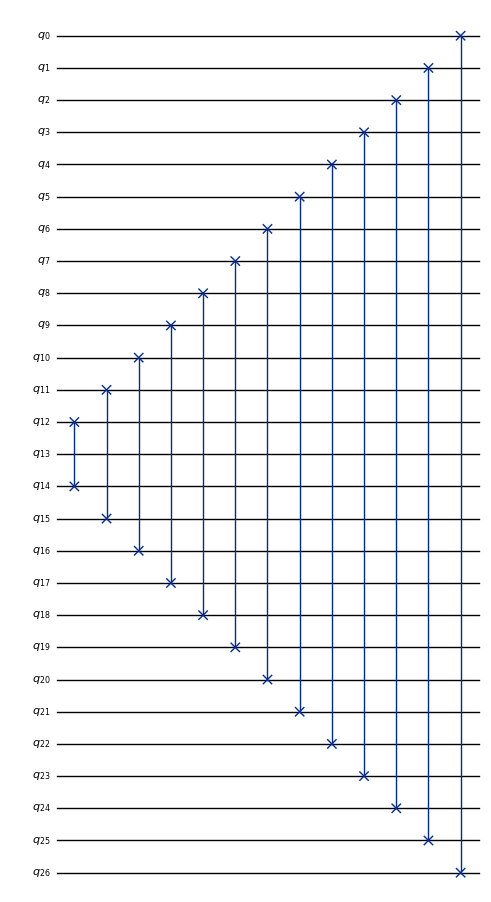

In [17]:
circuit_perm = QuantumCircuit(27)

perm = list(reversed(range(27)))
perm_gate = PermutationGate(perm)

# The permutation circuit
circuit_perm.append(perm_gate, qargs=range(27))
circuit_perm.decompose("permutation").draw(output="mpl", fold=-1, scale=0.5)

In [18]:
# AI synthesis
ai_synth_perm = AIPermutationSynthesis(
    coupling_map=list(coupling_map_27qHH.get_edges()),  # WIP (should be "coupling_map=...")
    replace_only_if_better=False
)

# Token swapper
ts_synth_perm = TokenSwapperSynthesisPermutation()

2q gates: 489 | 2q depth: 231


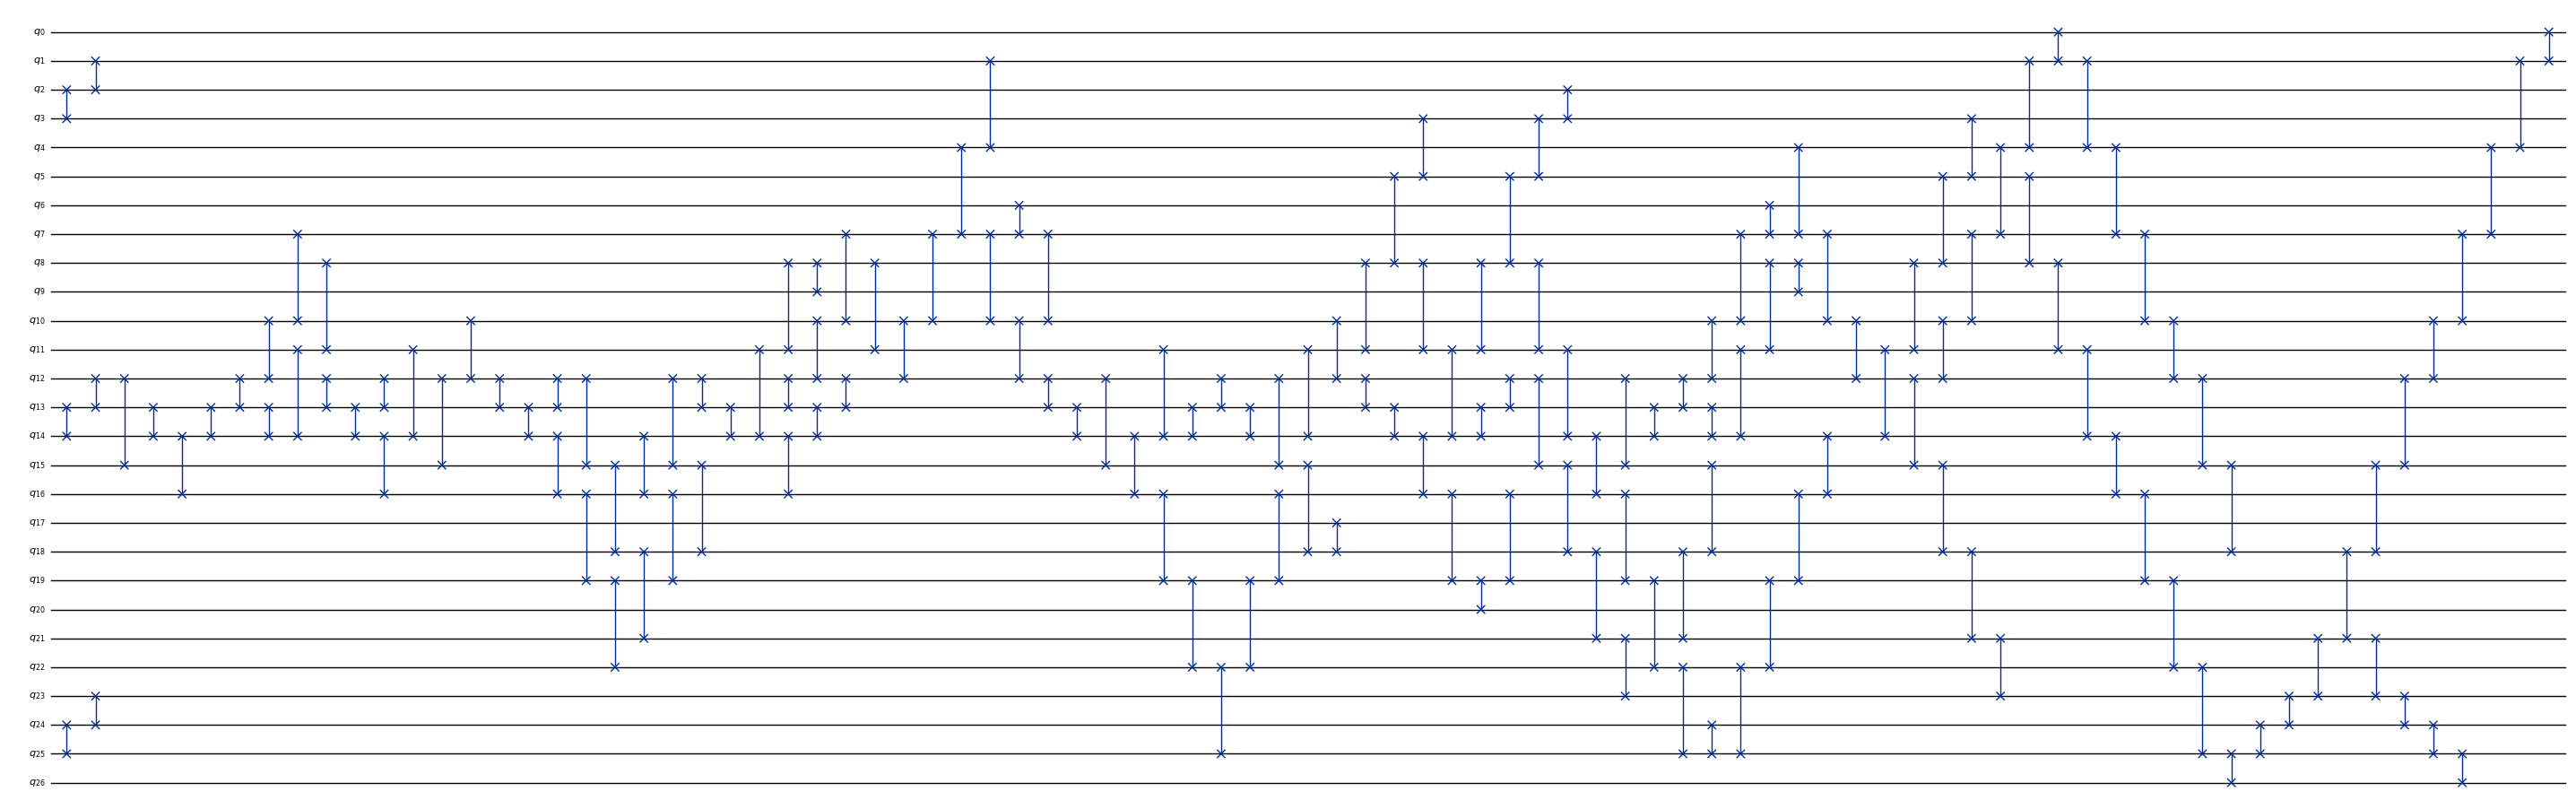

In [19]:
circuit_perm_ts = ts_synth_perm.run(perm_gate, coupling_map=coupling_map_27qHH, qubits=range(27))

print_2q_count_and_depth(circuit_perm_ts)
circuit_perm_ts.draw(output="mpl", fold=-1, scale=0.5)

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Permutations AI synthesis on local mode


2q gates: 423 | 2q depth: 96


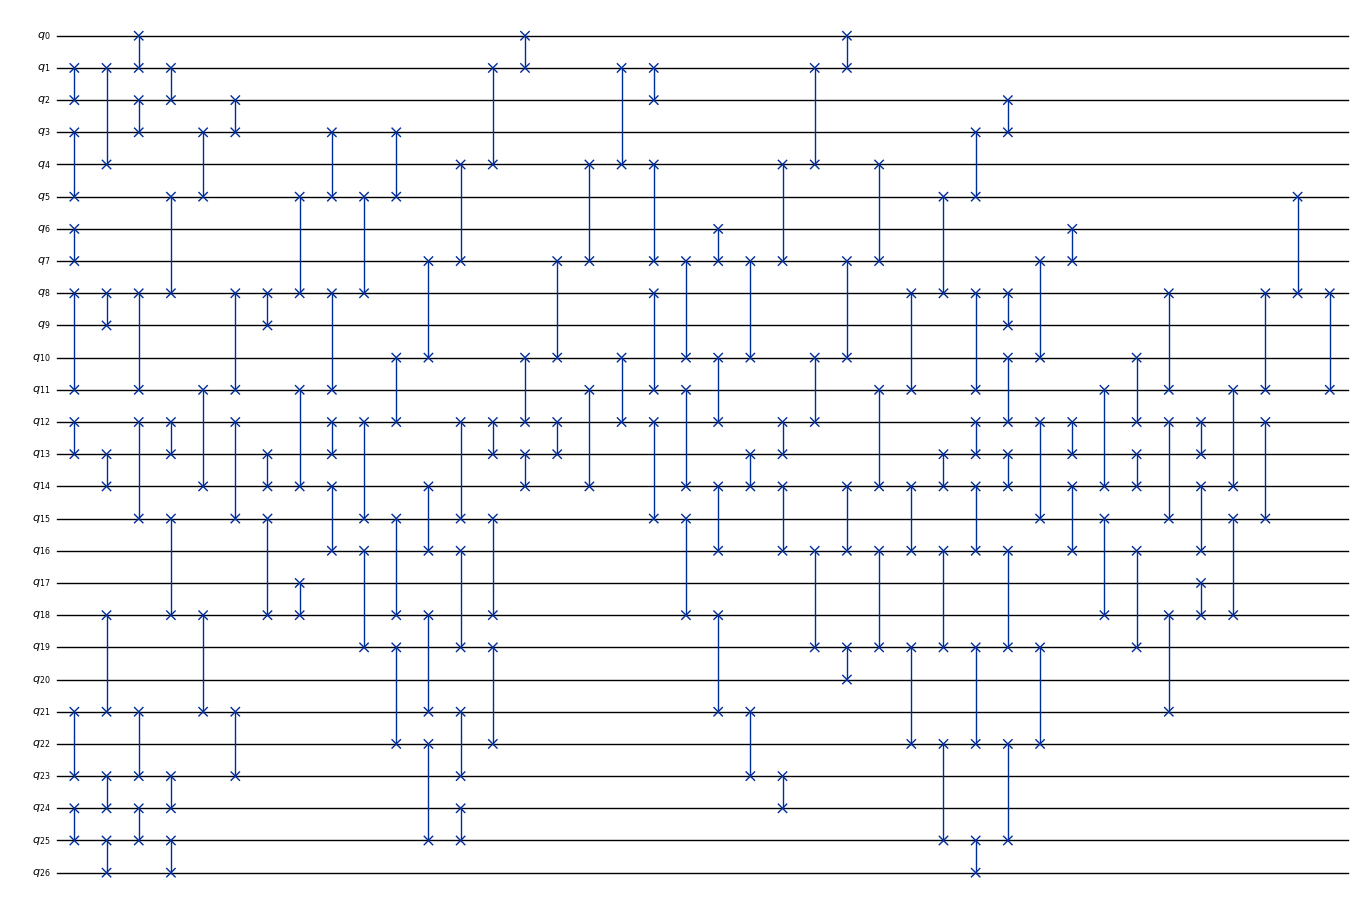

In [20]:
circuit_perm_ai = ai_synth_perm(circuit_perm)

print_2q_count_and_depth(circuit_perm_ai)
circuit_perm_ai.draw(output="mpl", fold=-1, scale=0.5)

In [21]:
calculate_2q_count_and_depth_improvement(circuit_perm_ts, circuit_perm_ai)


Improvement: 80.4% reduction in 2q gates

Improvement: 58.4% reduction in 2q depth


### 1.2 AI Routing

In the context of transpiling, Routing consists on inserting SWAP gates to make the 2q gates in a circuit compatible with a given coupling map.

Layout selection is a related task that consists on assigning physical qubits to the virtual qubits on the circuit. Typically, this two tasks are coupled together, since a good layout will make routing easier. 


Qiskit SDK provides a powerful Routing and Layout algorithm (`SabreSwap` and `SabreLayout`) that often provides a good routing solution efficiently. 

However, we have seen that this can be improved (sometimes by a large margin) with the AIRouting pass.

In [22]:
from qiskit_ibm_transpiler.ai.routing import AIRouting
from qiskit.transpiler.passes import SabreSwap, SabreLayout

Lets try routing circuits to a 12 qubit ring:

In [23]:
coupling_map_12qO = [(i, (i+1) % 12) for i in range(12)]   # A 12 qubit ring
coupling_map_12qO_qk = CouplingMap(coupling_map_12qO)
coupling_map_12qO_qk.make_symmetric()

Next, we create our passes. For just routing:

In [24]:
# AI routing, keeping current layout

ai_routing_3_keep = AIRouting(
    coupling_map=coupling_map_12qO,   # This can be a list or a CouplingMap object
    optimization_level=3,            # 1, 2 or 3
    layout_mode="keep",          # "keep", "improve" or "optimize" for layout
)

# SabreSwap, only routing and keeping layout

sabre_swap = SabreSwap(coupling_map=coupling_map_12qO_qk)

And, for optimizing both layout and routing:

In [25]:
# AI routing for optimizing layout

ai_routing_3_optimize = AIRouting(
    coupling_map=coupling_map_12qO,   # This can be a list or a CouplingMap object
    optimization_level=3,            # 1, 2 or 3
    layout_mode="optimize",          # "keep", "improve" or "optimize" for layout
)

# SabreLayout, doing both routing and layout optimization

sabre_layout = SabreLayout(coupling_map=coupling_map_12qO_qk)


We can now try the different methods some circuits:

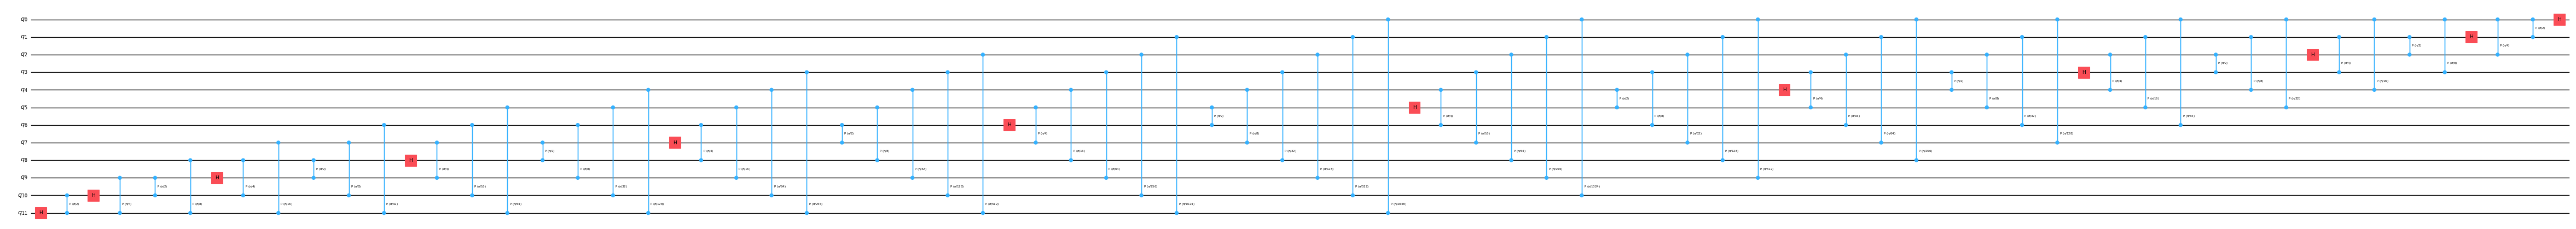

In [26]:
from qiskit.circuit.library import QFT

circuit = QFT(12, do_swaps=False).decompose()
circuit.draw(output="mpl", scale=0.5, fold=-1)

In [27]:
circuit_routed_ai_opt = fix_gate_names(ai_routing_3_optimize(circuit))

In [28]:
circuit_routed_ai_keep = fix_gate_names(ai_routing_3_keep(circuit))

In [29]:
circuit_routed_sabre_layout = sabre_layout(circuit)
circuit_routed_sabre_swap = sabre_swap(circuit)

AI routing
2q gates: 252 | 2q depth: 92


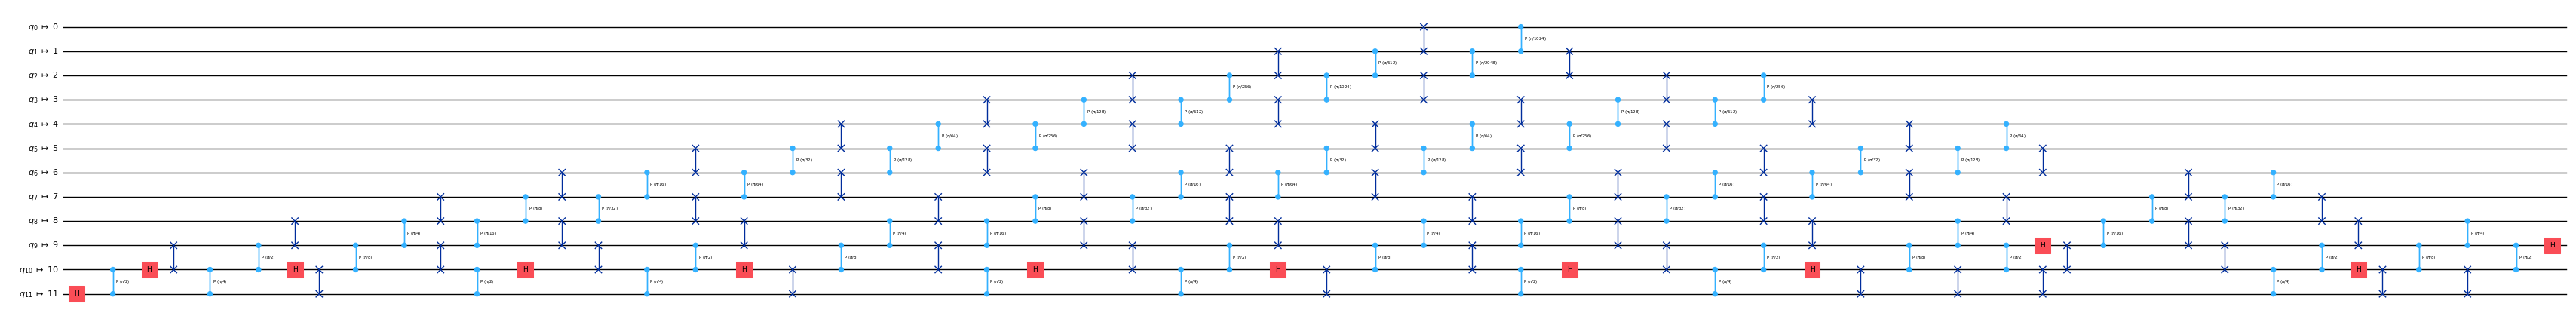

In [30]:
print("AI routing")
print_2q_count_and_depth(circuit_routed_ai_keep)
circuit_routed_ai_keep.draw(output="mpl", fold=-1, scale=0.5)

Sabre routing
2q gates: 291 | 2q depth: 114


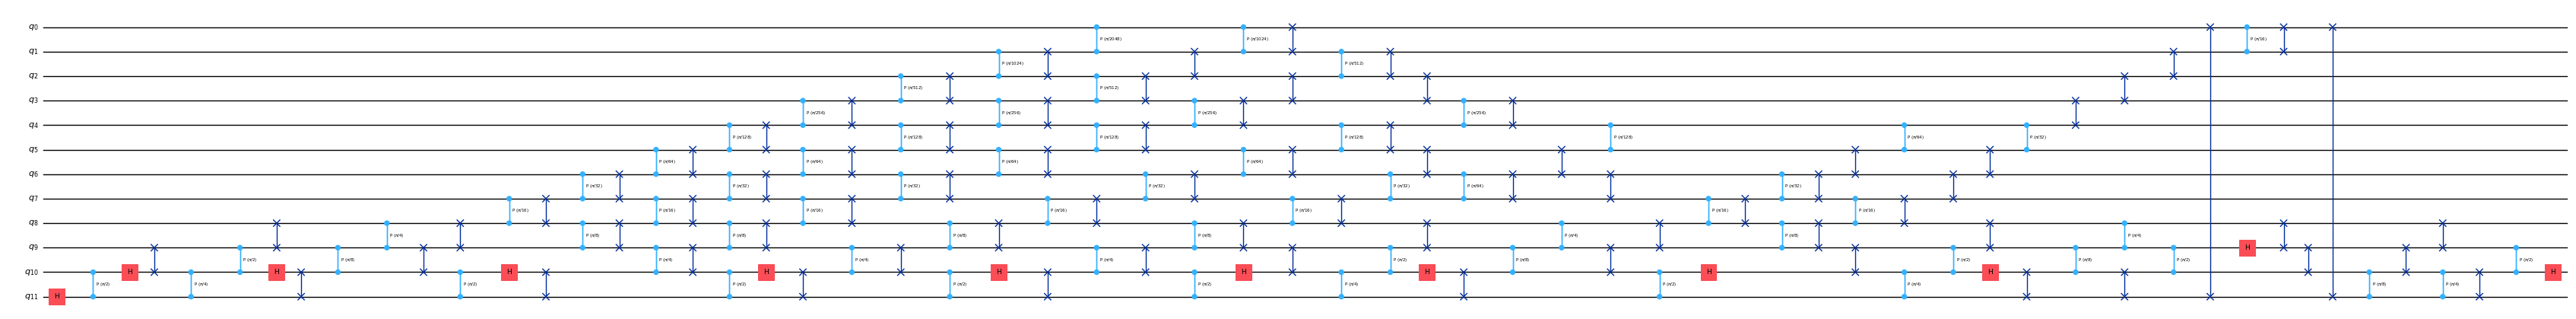

In [31]:
print("Sabre routing")
print_2q_count_and_depth(circuit_routed_sabre_swap)
circuit_routed_sabre_swap.draw(output="mpl", fold=-1, scale=0.5)

AI layout + routing
2q gates: 249 | 2q depth: 81


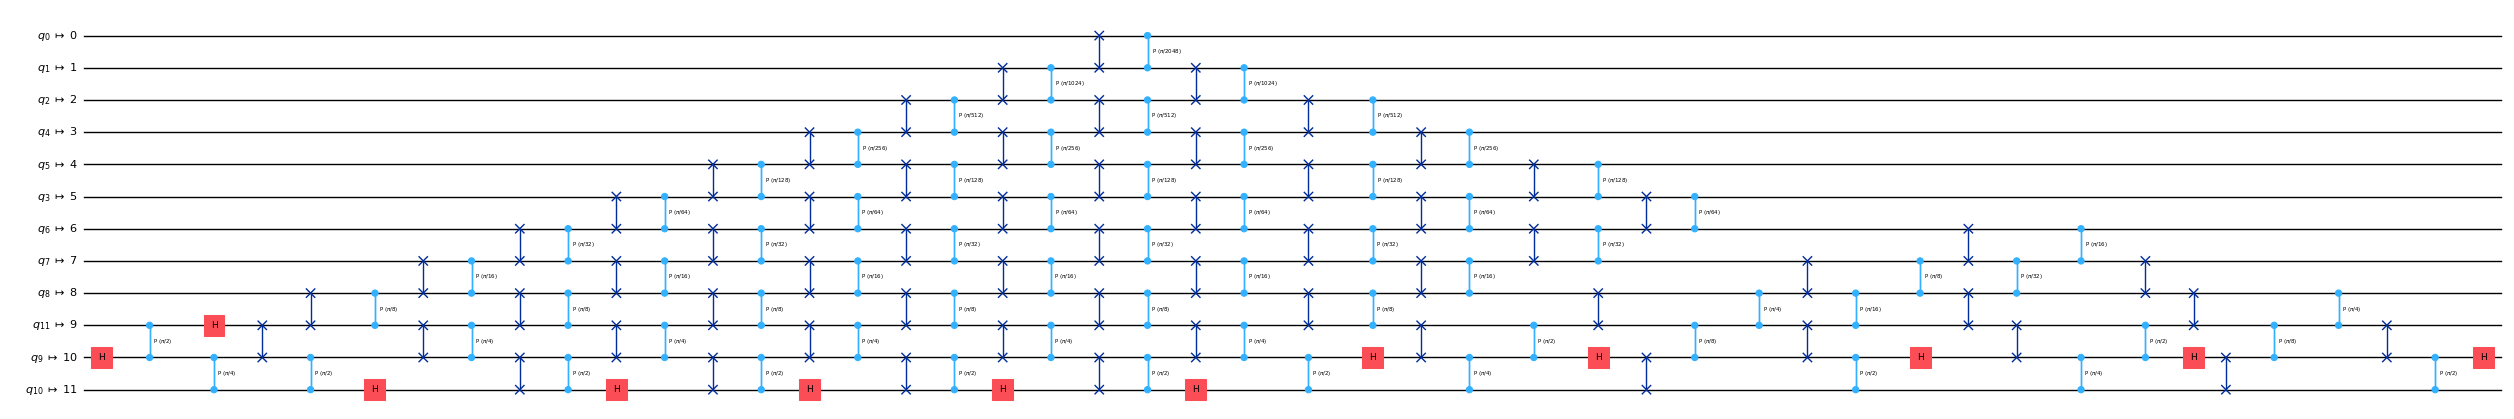

In [32]:
print("AI layout + routing")
print_2q_count_and_depth(circuit_routed_ai_opt)
circuit_routed_ai_opt.draw(output="mpl", fold=-1, scale=0.5)

Sabre layout + routing
2q gates: 300 | 2q depth: 136


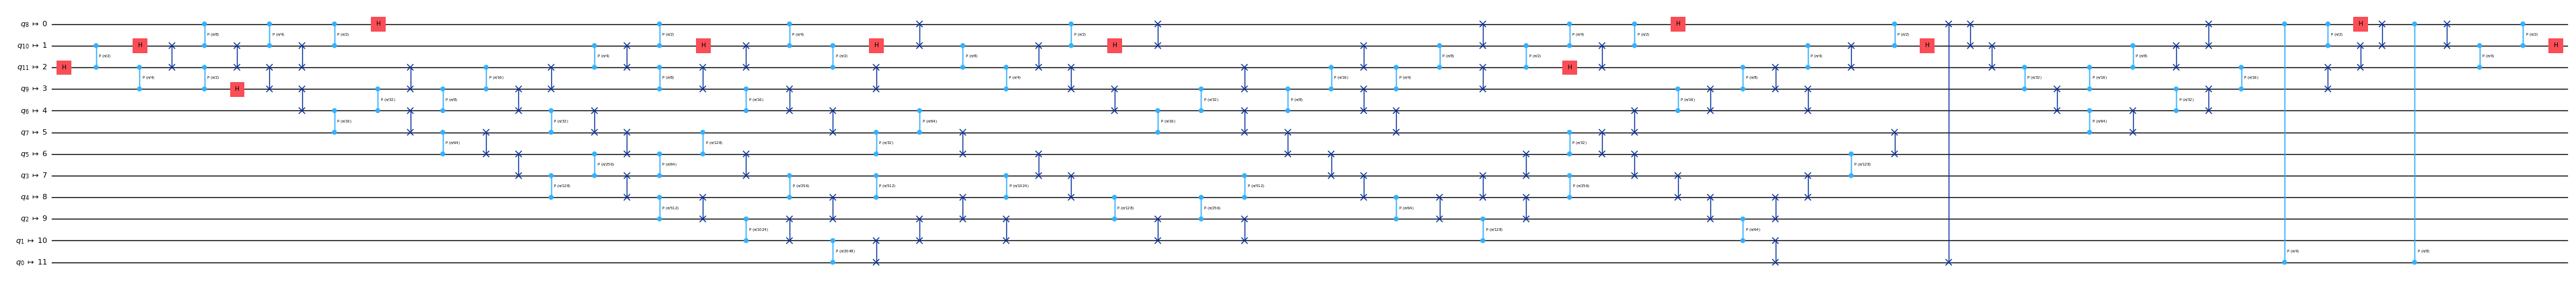

In [33]:
print("Sabre layout + routing")
print_2q_count_and_depth(circuit_routed_sabre_layout)
circuit_routed_sabre_layout.draw(output="mpl", fold=-1, scale=0.5)

### 1.2 Collecting and re-synthesizing circuit blocks

We can use the AI synthesis passes for additional optimization after routing, since they preserve the coupling map.

This can be done by first collecting blocks to be resinthesized, and then running the AI synthesis pass.

In [34]:
from qiskit_ibm_transpiler.ai.collection import CollectLinearFunctions, CollectCliffords, CollectPermutations

We can create a collection pass like this (in this case for LinearFunctions):

In [35]:
collect_lfs = CollectLinearFunctions(
    do_commutative_analysis=True,
    min_block_size=0,
    max_block_size=2,   # Max size supported for now
    collect_from_back=False
)

ai_lf_synth_12q = AILinearFunctionSynthesis(
    coupling_map=list(coupling_map_12qO_qk.get_edges()),
    replace_only_if_better=True,   # If the resynthesized circuit is "worse", we keep the original
)

First, we create a circuit and route it:

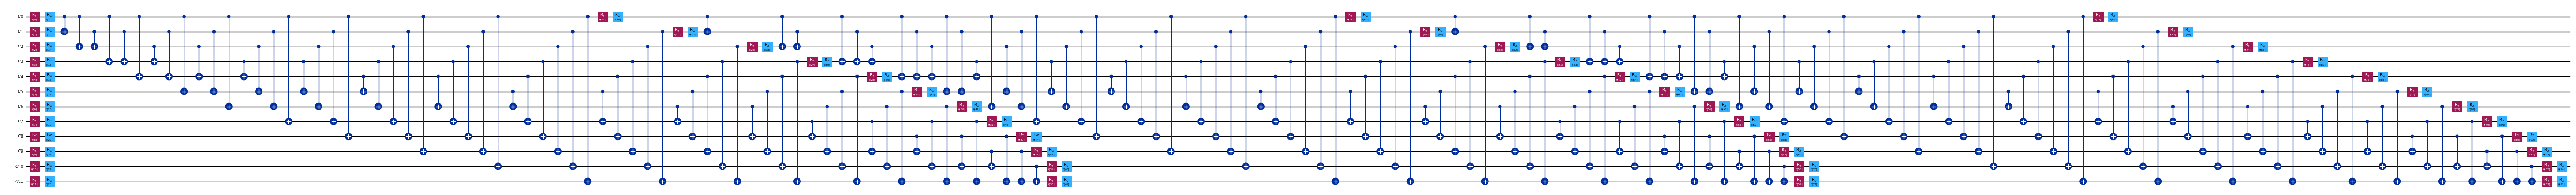

In [36]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(12, entanglement="full").decompose()
circuit.draw(output="mpl", scale=0.5, fold=-1)

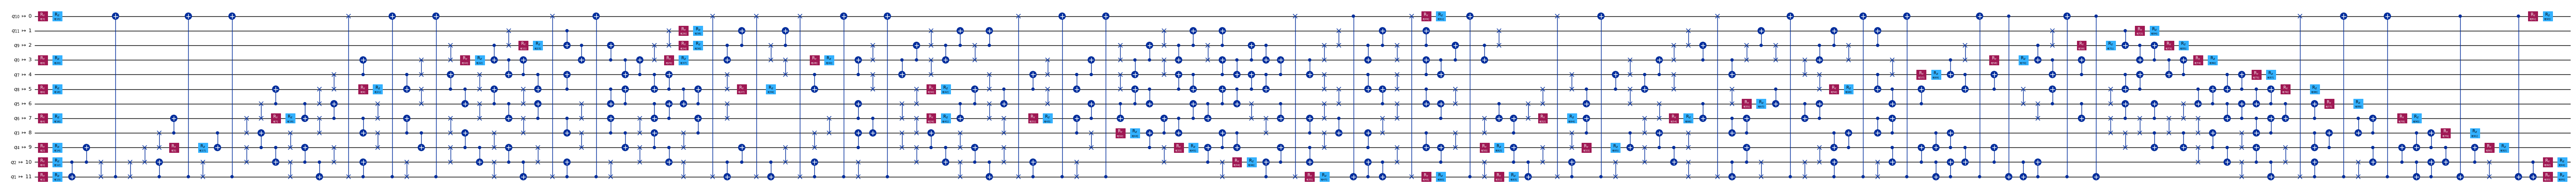

In [37]:
circuit_routed = ai_routing_3_optimize(circuit)
circuit_routed.draw(output="mpl", scale=0.5, fold=-1)

Then we run the pass on the circuit to get the blocks.

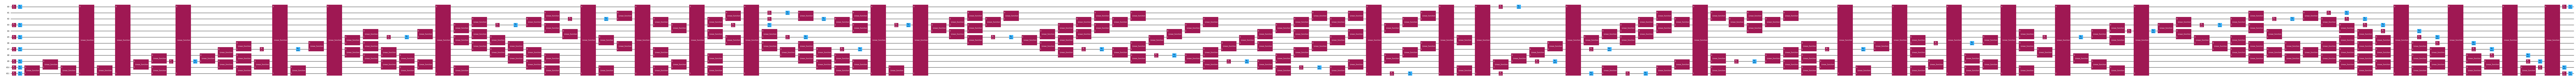

In [38]:
circuit_collected = collect_lfs(circuit_routed.decompose("swap"))
circuit_collected.draw(output="mpl", scale=0.5, fold=-1)

Finall, we run the synthesis pass to replace all the blocks with optimized versions:

In [39]:
circuit_optimized = ai_lf_synth_12q(circuit_collected)
print("Before optimization:")
print_2q_count_and_depth(circuit_routed)
print("After optimization:")
print_2q_count_and_depth(circuit_optimized)

calculate_2q_count_and_depth_improvement(circuit_routed, circuit_optimized)

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


Before optimization:
2q gates: 691 | 2q depth: 234
After optimization:
2q gates: 502 | 2q depth: 164

Improvement: 76.3% reduction in 2q gates

Improvement: 29.9% reduction in 2q depth


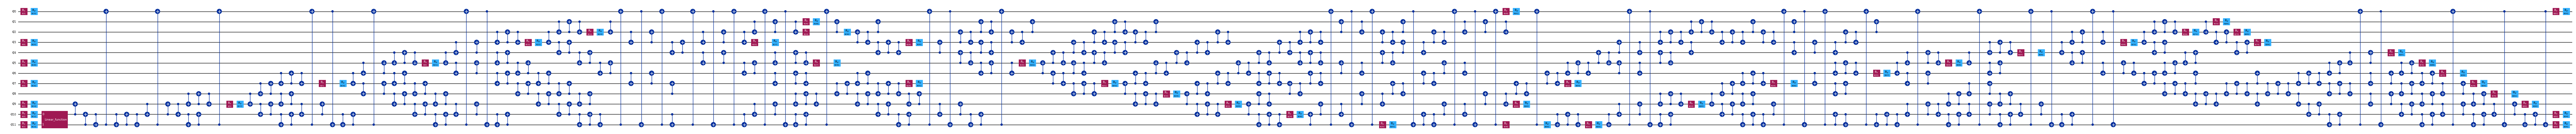

In [40]:
circuit_optimized.draw(output="mpl", scale=0.5, fold=-1)

### *Hands-on exercise*:
*Create a custom `PassManager` that includes AI routing, block collection and AI synthesis and run it on some circuits.*

In [41]:
from qiskit.transpiler import PassManager
#...

In [42]:
ai_transpiling = PassManager([
    ai_routing_3_optimize,
    collect_lfs,
    ai_lf_synth_12q
])

In [43]:
circuit_ai_transpiled = ai_transpiling.run(circuit)

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


2q gates: 526 | 2q depth: 173


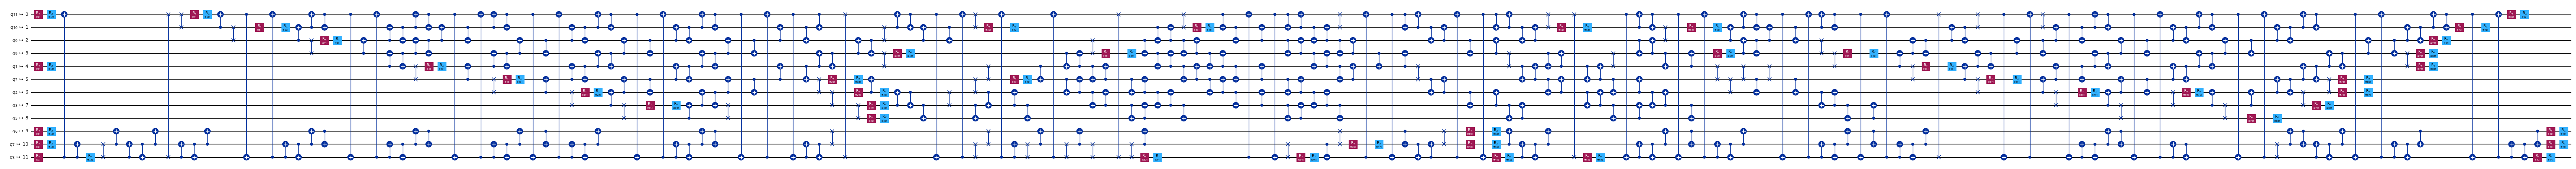

In [44]:
print_2q_count_and_depth(circuit_ai_transpiled)
circuit_ai_transpiled.draw(output="mpl", scale=0.5, fold=-1)

# 2. Hybrid Heuristic-AI Circuit Transpilation

The `generate_ai_pass_manager()` function provides a convenient way to create a hybrid pass manager that combines Qiskit's traditional heuristic transpiler passes with AI-powered optimization passes.

This approach gives you the benefits of both worlds:
- **Heuristic passes**: Fast, reliable, and well-tested traditional optimization
- **AI passes**: Advanced optimization that can find better solutions for complex circuits

The hybrid pass manager automatically orchestrates the combination of these approaches for optimal results.

In [45]:
from qiskit_ibm_transpiler import generate_ai_pass_manager
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime.fake_provider.backends.torino import FakeTorino

# Get a backend coupling map (using Torino as example)
backend = FakeTorino()
torino_coupling_map = backend.coupling_map

print(f"Torino coupling map: {torino_coupling_map.size()} qubits, {len(torino_coupling_map.get_edges())} edges")

Torino coupling map: 133 qubits, 300 edges


Let's create a test circuit and compare different transpilation approaches:

In [46]:
# Create a test circuit
# su2_circuit = EfficientSU2(101, entanglement="circular", reps=1).decompose()
circuit = QFT(12, do_swaps=False).decompose()
print(f"Original circuit: {circuit.num_qubits} qubits, {circuit.size()} gates")
print_2q_count_and_depth(circuit)

Original circuit: 12 qubits, 78 gates
2q gates: 66 | 2q depth: 21


Now let's create different pass managers and compare their results:

In [47]:
# 1. Standard Qiskit transpiler
from qiskit import generate_preset_pass_manager

standard_pm = generate_preset_pass_manager(
    coupling_map=torino_coupling_map,
    optimization_level=3,
    basis_gates=["cx", "id", "rz", "sx", "x"]
)

# 2. Hybrid AI-enhanced pass manager
ai_hybrid_pm = generate_ai_pass_manager(
    coupling_map=torino_coupling_map,
    ai_optimization_level=3,       # AI component optimization level
    optimization_level=3,          # Heuristic component optimization level
    ai_layout_mode="optimize"      # AI routing layout mode
)

print("Pass managers created successfully!")

Pass managers created successfully!


Let's run both pass managers and compare the results:

In [48]:
# Transpile with standard Qiskit
print("Running standard Qiskit transpilation...")
standard_result = standard_pm.run(circuit)
print("Standard Qiskit results:")
print_2q_count_and_depth(standard_result)

# Transpile with hybrid AI pass manager
print("\nRunning hybrid AI transpilation...")
ai_hybrid_result = ai_hybrid_pm.run(circuit)
print("Hybrid AI results:")
print_2q_count_and_depth(ai_hybrid_result)


calculate_2q_count_and_depth_improvement(standard_result, ai_hybrid_result)

Running standard Qiskit transpilation...
Standard Qiskit results:
2q gates: 242 | 2q depth: 126

Running hybrid AI transpilation...


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

Hybrid AI results:
2q gates: 243 | 2q depth: 101

Improvement: 58.3% reduction in 2q gates

Improvement: 19.8% reduction in 2q depth


### Key Parameters for `generate_ai_pass_manager()`

The `generate_ai_pass_manager()` function accepts several important parameters:

- **`coupling_map`**: The device coupling map (required)
- **`ai_optimization_level`**: Optimization level for AI passes (1-3, higher = more optimization)
- **`optimization_level`**: Optimization level for heuristic passes (1-3, higher = more optimization) 
- **`ai_layout_mode`**: How AI routing handles layout ("keep", "improve", or "optimize")
- **`basis_gates`**: Target basis gates (optional, defaults to common gate set)

You can experiment with different combinations to find the best balance between compile time and optimization quality for your specific circuits.

### *Hands-on exercise*:
*Try different combinations of `ai_optimization_level`, `optimization_level`, and `ai_layout_mode` to see how they affect the results. Compare compile times and optimization quality.*

In [ ]:
# Example: Try different parameter combinations
# Uncomment to experiment:

# # Conservative approach (faster, less optimization)
# conservative_pm = generate_ai_pass_manager(
#     coupling_map=torino_coupling_map,
#     ai_optimization_level=1,
#     optimization_level=2,
#     ai_layout_mode="improve"
# )

# # Aggressive approach (slower, more optimization)  
# aggressive_pm = generate_ai_pass_manager(
#     coupling_map=torino_coupling_map,
#     ai_optimization_level=3,
#     optimization_level=3,
#     ai_layout_mode="optimize"
# )

## *3. Final hands-on exercise:*
*Combine AI passes with other specialized passes to build custom pipelines, and try it on your circuits!*

Find other examples on how to use the `qiskit-ibm-transpiler` library and the AI-powered transpiler passes in https://github.com/Qiskit/qiskit-ibm-transpiler/blob/main/examples/